## Data Preprocessing
Split grade data per degrees

In [5]:
import pandas as pd

# Load grades data
grades = pd.read_csv('notes_assignatures.csv', header=None, names=[
    'Degree', 'Academic_Year', 'Student_ID', 'Gender', 'Subject', 'Subject_Code', 'Grade'
])

# Filter valid grades
grades['Grade'] = pd.to_numeric(grades['Grade'], errors='coerce')
grades.dropna(subset=['Grade'], inplace=True)

# Split by degree
grades['Degree_Program'] = grades['Degree'].apply(
    lambda x: 'Computer Engineering' if 'Enginyeria Informàtica' in x 
    else 'AI' if 'Intel·ligència Artificial' in x 
    else 'Other'
)

Split occupancy data per degrees

In [6]:
# Load occupancy data (adjust for both academic years)
occupancy = pd.concat([
    pd.read_csv('ocupacio_aules_EE_23_24_v06.csv', header=None),
    pd.read_csv('ocupacio_aules_EE_24_25_v06.csv', header=None)
], ignore_index=True)

occupancy.columns = [
    'Date_Start', 'Time_Start', 'Date_End', 'Time_End', 'Duration', 'Room', 
    'Degree', 'Subject_Info', 'Enrollment_Count'
]

# Split by degree (using degree codes)
occupancy['Degree_Program'] = occupancy['Degree'].apply(
    lambda x: 'Computer Engineering' if '10062' in x  # Code for Enginyeria Informàtica
    else 'AI' if '10130' in x  # Code for Intel·ligència Artificial
    else 'Other'
)

In [8]:
print("Unique degree programs in grades data:")
print(grades['Degree_Program'].unique())

print("\nUnique degree programs in occupancy data:")
print(occupancy['Degree_Program'].unique())

Unique degree programs in grades data:
['Computer Engineering' 'AI']

Unique degree programs in occupancy data:
['Computer Engineering' 'AI']


## Data Analysis

In [ ]:
# Aggregate by subject (average grade, pass rate, etc.)
subject_stats = grades.groupby(['Degree_Program', 'Subject', 'Subject_Code']).agg({
    'Grade': ['mean', 'median', 'count'],
    'Academic_Year': 'nunique'  # How many years the subject was taught
}).reset_index()
subject_stats.columns = ['Degree_Program', 'Subject', 'Subject_Code', 'Avg_Grade', 'Median_Grade', 'Total_Students', 'Years_Taught']

display(subject_stats.head())

,Degree_Program,Subject,Subject_Code,Avg_Grade,Median_Grade,Total_Students,Years_Taught
0,AI,Acceleració de la Computació en IA,106592,0.000000,0.0,7,1
1,AI,Agents Autònoms,106587,3.958333,2.5,72,2
2,AI,Anàlisi de Grafs i Xarxes,106567,4.499225,6.0,129,3
3,AI,Aprenentatge Automàtic Avançat,106575,7.733333,7.4,21,1
4,AI,Aprenentatge i Processament del Llenguatge Nat...,106585,6.603448,8.5,29,2


In [11]:
occupancy['Subject_Code'] = occupancy['Subject_Info'].str.extract(r'(\d{5,6})').astype(int)

# Clean Enrollment_Count: Convert to numeric, drop invalid rows
occupancy['Enrollment_Count'] = pd.to_numeric(occupancy['Enrollment_Count'], errors='coerce')
occupancy.dropna(subset=['Enrollment_Count'], inplace=True)

# Fix: Specify dayfirst=True and correct format
occupancy['Datetime_Start'] = pd.to_datetime(
    occupancy['Date_Start'] + ' ' + occupancy['Time_Start'], 
    dayfirst=True,  # Critical for European date formats
    format='%d/%m/%Y %H:%M'  # Explicit format to avoid ambiguity
)
# Proceed with hour/day extraction
occupancy['Hour'] = occupancy['Datetime_Start'].dt.hour
occupancy['Day_of_Week'] = occupancy['Datetime_Start'].dt.day_name()

# Aggregate occupancy by subject + time slot
occupancy_stats = occupancy.groupby(['Degree_Program', 'Subject_Code', 'Hour', 'Day_of_Week']).agg({
    'Enrollment_Count': 'mean',
    'Room': 'nunique'  # How many rooms used
}).reset_index()

display(occupancy_stats.head())

,Degree_Program,Subject_Code,Hour,Day_of_Week,Enrollment_Count,Room
0,AI,106550,17,Tuesday,42.000000,2
1,AI,106551,15,Monday,47.000000,1
2,AI,106551,15,Wednesday,47.000000,1
3,AI,106552,15,Tuesday,44.870968,2
4,AI,106552,17,Thursday,45.250000,3


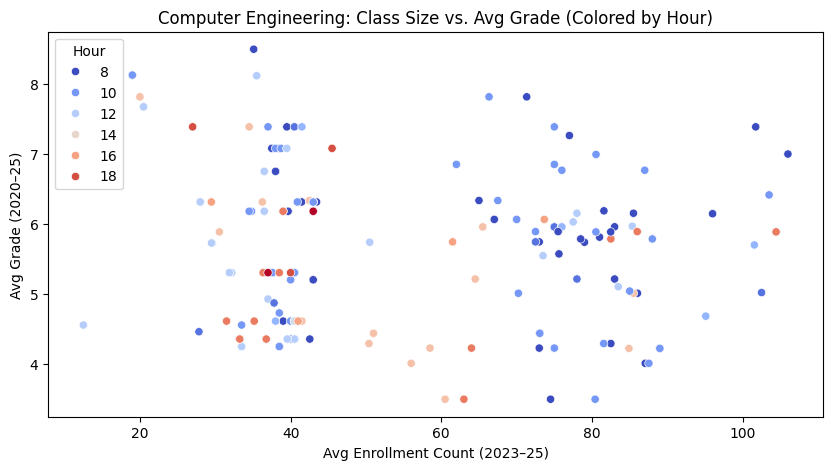

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge for Computer Engineering
ce_analysis = pd.merge(
    subject_stats[subject_stats['Degree_Program'] == 'Computer Engineering'],
    occupancy_stats[occupancy_stats['Degree_Program'] == 'Computer Engineering'],
    on='Subject_Code',
    how='inner'
)

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=ce_analysis,
    x='Enrollment_Count',
    y='Avg_Grade',
    hue='Hour',
    palette='coolwarm'
)
plt.title("Computer Engineering: Class Size vs. Avg Grade (Colored by Hour)")
plt.xlabel("Avg Enrollment Count (2023–25)")
plt.ylabel("Avg Grade (2020–25)")
plt.show()

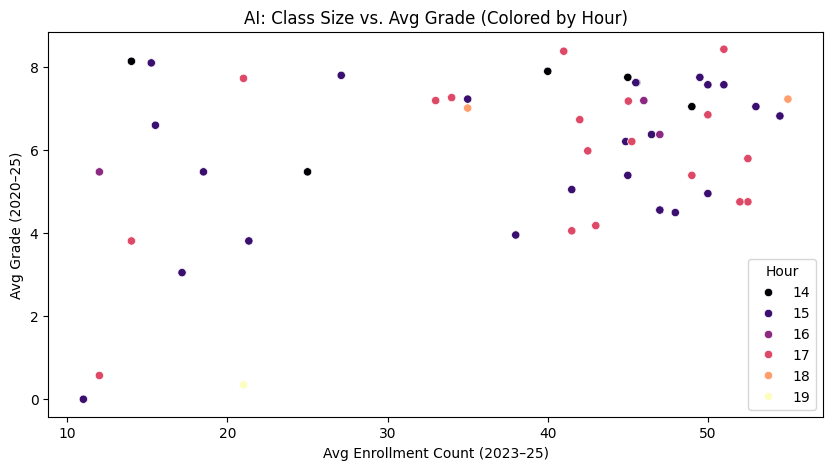

In [14]:
# Merge for AI
ai_analysis = pd.merge(
    subject_stats[subject_stats['Degree_Program'] == 'AI'],
    occupancy_stats[occupancy_stats['Degree_Program'] == 'AI'],
    on='Subject_Code',
    how='inner'
)

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=ai_analysis,
    x='Enrollment_Count',
    y='Avg_Grade',
    hue='Hour',
    palette='magma'
)
plt.title("AI: Class Size vs. Avg Grade (Colored by Hour)")
plt.xlabel("Avg Enrollment Count (2023–25)")
plt.ylabel("Avg Grade (2020–25)")
plt.show()

In [ ]:
# Compare avg class sizes and grades
print("Computer Engineering Stats:")
print(ce_analysis[['Enrollment_Count', 'Avg_Grade']].describe())

print("\nArtificial Intelligence Stats:")
print(ai_analysis[['Enrollment_Count', 'Avg_Grade']].describe())

Computer Engineering Stats:
       Enrollment_Count   Avg_Grade
count        178.000000  178.000000
mean          55.021372    5.708307
std           22.467730    1.129572
min           12.500000    3.500986
25%           37.651613    4.616895
50%           43.000000    5.802784
75%           75.000000    6.317816
max          106.000000    8.499038

Artificial Intelligence Stats:
       Enrollment_Count  Avg_Grade
count         55.000000  55.000000
mean          38.209039   5.840364
std           13.781136   2.075162
min           11.000000   0.000000
25%           26.051724   4.757937
50%           44.870968   6.380159
75%           49.000000   7.252177
max           55.000000   8.436066


In [16]:
# For Computer Engineering problem subjects
ce_best_slots = ce_analysis.groupby(['Hour', 'Day_of_Week'])['Avg_Grade'].mean().sort_values(ascending=False).head(3)
print("Computer Engineering - Best Slots:")
for (hour, day), grade in ce_best_slots.items():
    print(f"{day} at {hour}:00 (Avg Grade: {grade:.1f})")

# For AI problem subjects
ai_best_slots = ai_analysis.groupby(['Hour', 'Day_of_Week'])['Avg_Grade'].mean().sort_values(ascending=False).head(3)
print("\nAI - Best Slots:")
for (hour, day), grade in ai_best_slots.items():
    print(f"{day} at {hour}:00 (Avg Grade: {grade:.1f})")

Computer Engineering - Best Slots:
Tuesday at 18:00 (Avg Grade: 7.4)
Monday at 18:00 (Avg Grade: 7.1)
Monday at 12:00 (Avg Grade: 6.2)

AI - Best Slots:
Monday at 14:00 (Avg Grade: 8.1)
Monday at 16:00 (Avg Grade: 7.2)
Monday at 18:00 (Avg Grade: 7.1)


In [17]:
# 1. Save subject_stats (grades aggregation)
subject_stats.to_csv('grades_processed.csv', index=False)

# 2. Save occupancy_stats (occupancy aggregation)
occupancy_stats.to_csv('occupancy_processed.csv', index=False)

print("Files saved successfully:")
print("- grades_processed.csv (Subject statistics)")
print("- occupancy_processed.csv (Occupancy statistics)")

Files saved successfully:
- grades_processed.csv (Subject statistics)
- occupancy_processed.csv (Occupancy statistics)
